## **RUNS THE SIMULATION ON A VERY SMALL SAMPLE GRAPH**

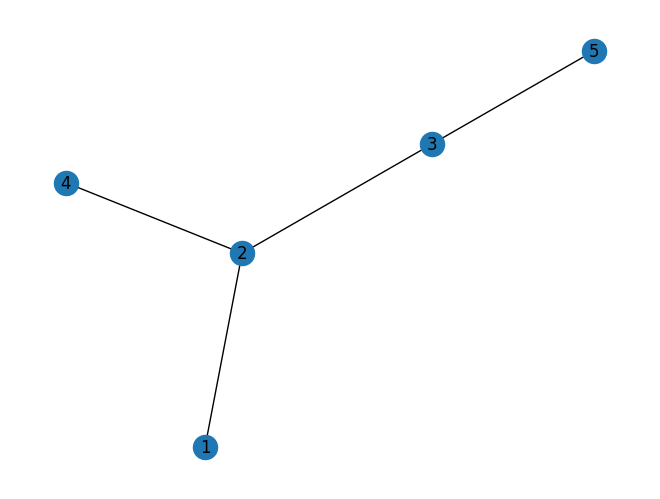

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json

# Start with a simple graph (not paris metro)
# create an object that is a simulator

G = nx.Graph()
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_node(5)
G.add_edge(1,2,label = "A")
G.add_edge(2,3, label = "A")
G.add_edge(2,4, label = "B")
G.add_edge(3, 5, label = "C")

# Assume you have a dictionary 'station_coordinates' with station names as keys and (latitude, longitude) tuples as values
station_coordinates = {
    1: (48.8566, 2.3522),  # Example coordinates for station 1
    2: (48.8606, 2.3428),
    3: (48.8574, 2.3657),
    4: (48.8626, 2.3350),
    5: (48.8535, 2.3734),
}

nx.draw(G, with_labels = True)
plt.show()

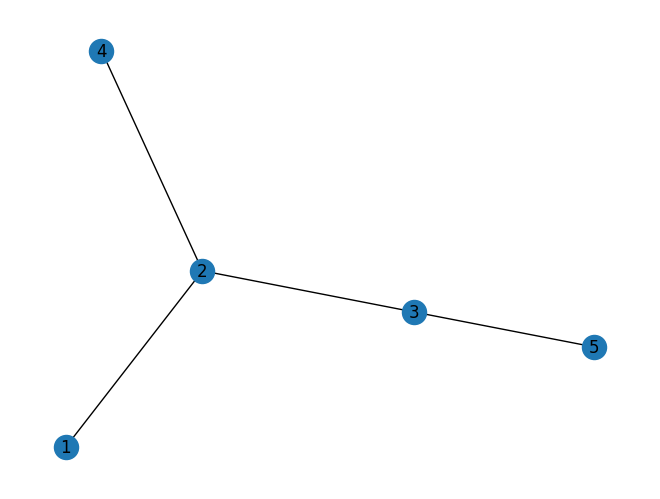

Node 1: ({2: 0.6, 3: 0.13333333333333333, 4: 0.13333333333333333, 5: 0.13333333333333333}, 6.676087090061166)
Node 2: ({1: 0.2, 3: 0.2, 4: 0.2, 5: 0.4000000000000001}, 6.714235618375466)
Node 3: ({1: 0.2, 2: 0.3, 4: 0.2, 5: 0.3}, 9.056250485129535)
Node 4: ({1: 0.13333333333333333, 2: 0.6, 3: 0.13333333333333333, 5: 0.13333333333333333}, 9.340155952879604)
Node 5: ({1: 0.13333333333333333, 2: 0.13333333333333333, 3: 0.6, 4: 0.13333333333333333}, 9.635996516277942)
Node 1: Lambda = 6.676087090061166
Node 2: Lambda = 6.714235618375466
Node 3: Lambda = 9.056250485129535
Node 4: Lambda = 9.340155952879604
Node 5: Lambda = 9.635996516277942


In [ ]:
# Updated on 3/27/25 to make the probability distribution not random
# Test out the inputs function for the simple G graph

def inputs():
    for station in G.nodes():
        random_probs = {}

        # Get shortest path lengths from the current station
        shortest_paths = nx.shortest_path_length(G, source=station)

        # Buckets for different travel distances
        medium_trip = [] # >=2 stops
        short_trip = []  # <2 stops

        for node, distance in shortest_paths.items():
            if node == station:
                continue  # Skip self
            if distance >= 2:
                medium_trip.append(node)
            else:
                short_trip.append(node)

        # Assign probabilities based on the given distribution
        total_nodes = len(medium_trip) + len(short_trip)

        if total_nodes > 0:
            p_medium = 0.4 / max(1, len(medium_trip))
            p_short = 0.6 / max(1, len(short_trip))

            for node in medium_trip:
                random_probs[node] = p_medium
            for node in short_trip:
                random_probs[node] = p_short

        # Normalize the probabilities to sum to 1
        total_prob = sum(random_probs.values())
        if total_prob > 0:
            random_probs = {k: v / total_prob for k, v in random_probs.items()}

        # Assign a random lambda value (to be overwritten later)
        lambda_value = np.random.uniform(2, 10)

        # Store in graph
        G.nodes[station]["lambda"] = lambda_value # Modified line
        G.nodes[station]["data"] = (random_probs, lambda_value)

    return G

G = inputs()

# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

# Print the probability distribution for each node
for node in G.nodes():
    probs, lambda_val = G.nodes[node]['data']  # Unpack the tuple
    sorted_probs = dict(sorted(probs.items()))  # Sort the probabilities dictionary by key (destination node)
    print(f"Node {node}: ({sorted_probs}, {lambda_val})")

for node in G.nodes():
    print(f"Node {node}: Lambda = {G.nodes[node]['lambda']}")

In [ ]:
# 3/27/25: I have not updated the following based on the changes made to the probability distribution as shown above

import networkx as nx
import numpy as np
import pandas as pd
import json

def update_node_with_lambda(G, lambda_dictionary):
  for node in G.nodes():
    G.nodes[node]["lambda"] = lambda_dictionary[node]
  return G

def inputs():
    # Assign probability distributions and lambda values to each node
    for station in G.nodes():
        random_probs = {}
        for node in G.nodes():
            if node != station:
                random_probs[node] = np.random.rand()
            else :
                random_probs[node] = 0
        total = sum(random_probs.values())
        normalized_probs = {k: v / total for k, v in random_probs.items()}  # Normalize to sum to 1
        lambda_value = np.random.uniform(2, 10) # This line doesn't matter because these lambda values get overwritten
        G.nodes[station]["prob"] = normalized_probs
        G.nodes[station]["lambda"] = lambda_value
    return G

def simulate_arrivals(G, days):
    """Generates passenger arrivals at each station using a Poisson distribution."""
    arrivals = {}
    for station in G.nodes():
        _, lambda_value = G.nodes[station]["data"]
        arrivals[station] = np.random.poisson(lam=lambda_value, size=days)
    return arrivals

def simulate_passenger_journeys(G, daily_arrivals):
    journeys = []

    for station, arrivals in daily_arrivals.items():
        total_passengers = sum(arrivals)  # Total passengers arriving in the day

        for _ in range(total_passengers):
            destination = np.random.choice(stations)  # Random destination
            while destination == station:
                destination = np.random.choice([s for s in stations if s != station])

            path_nodes = nx.shortest_path(G, source=station, target=destination)
            path_edges = [(path_nodes[i], path_nodes[i + 1]) for i in range(len(path_nodes) - 1)]
            path_line_number = nx.get_edge_attributes(G, "label")
            path_length = nx.get_edge_attributes(G, "length")
            journeys.append(path_nodes)

    return journeys

def calculate_avg_transfers(G, results):
    """Calculates the average number of transfers that someone who starts at each station would have to make to get to their final destination."""

    station_transfers = {}  # Store total transfers for each starting station
    station_counts = {}    # Store the number of journeys starting from each station

    for person_id, journey in enumerate(results):
        start_station = journey[0]  # Get the starting station for this journey

        # If this is the first journey from this station, initialize counts
        station_transfers.setdefault(start_station, 0)
        station_counts.setdefault(start_station, 0)

        # Count the transfers for this journey (same logic as before)
        transfers = 0
        if len(journey) > 2:
            for i in range(len(journey) - 2):
                current_edge = (journey[i], journey[i + 1])
                next_edge = (journey[i + 1], journey[i + 2])
                if G.get_edge_data(*current_edge).get("label") != G.get_edge_data(*next_edge).get("label"):
                    transfers += 1

        station_transfers[start_station] += transfers  # Add transfers for this journey
        station_counts[start_station] += 1           # Increment journey count for this station

    # Calculate averages
    avg_transfers = {}
    for station in station_transfers:
        avg_transfers[station] = station_transfers[station] / station_counts[station]

    return avg_transfers


# Example usage
lambda_dictionary = {1: 5, 2: 6, 3: 7, 4: 8, 5: 9} # UPDATE TO THE DICTIONARY FROM PARIS
G = inputs()
stations = list(G.nodes())
daily_arrivals = simulate_arrivals(G, 1)
G = update_node_with_lambda(G, lambda_dictionary)
results = simulate_passenger_journeys(G, daily_arrivals) # Run the simulation

print(results)
print(G.nodes[1]["lambda"]) # Prints the path that each person in the simulation took

# Create a list to store the data for the DataFrame
data = []
for i, journey in enumerate(results):
    data.append({'person_id': i + 1, 'path': journey})  # Store the entire path

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Print the DataFrame
display(df)

# Calculate and print the average transfers
avg_transfers_result = calculate_avg_transfers(G, results)
print("The average # transfers a person who starts at each station needs to make to get to their destination")
print(avg_transfers_result)

[[1, 2, 3], [1, 2, 4], [1, 2, 3], [1, 2, 3, np.int64(5)], [1, 2, 3, np.int64(5)], [1, 2, 3, np.int64(5)], [1, 2, 3, np.int64(5)], [1, 2, 3, np.int64(5)], [1, 2, 3], [2, 3, np.int64(5)], [2, 4], [2, 3], [2, 3], [2, 3, np.int64(5)], [2, 1], [2, 4], [2, 3], [2, 1], [2, 1], [3, 2, np.int64(4)], [3, 2, np.int64(1)], [3, 2], [3, 2], [3, 5], [3, 2, np.int64(1)], [4, 2, 3], [4, 2, 1], [4, 2, 3, np.int64(5)], [4, 2, 1], [4, 2], [4, 2], [4, 2, 3], [4, 2, 3], [4, 2, 1], [4, 2], [4, 2], [5, 3, 2, 4], [5, 3, 2, 1], [5, 3, 2, 1], [5, 3], [5, 3, 2, 1], [5, 3, 2, 1], [5, 3, 2, 4], [5, 3, 2], [5, 3, 2, 4], [5, 3, 2, 1]]
5


,person_id,path
0,1,"[1, 2, 3]"
1,2,"[1, 2, 4]"
2,3,"[1, 2, 3]"
3,4,"[1, 2, 3, 5]"
4,5,"[1, 2, 3, 5]"
5,6,"[1, 2, 3, 5]"
6,7,"[1, 2, 3, 5]"
7,8,"[1, 2, 3, 5]"
8,9,"[1, 2, 3]"
9,10,"[2, 3, 5]"


The average # transfers a person who starts at each station needs to make to get to their destination
{1: 0.6666666666666666, 2: 0.2, 3: 0.16666666666666666, 4: 0.7272727272727273, 5: 1.2}


In [ ]:
# 3/27/25: I have not updated the following based on the changes made to the probability distribution as shown above

def find_changing_stations(G, results):
    changing_stations_per_person = {}  # Dictionary to store changing stations for each person

    for person_id, journey in enumerate(results):
        changing_stations = []

        if len(journey) > 2:  # Only check for changes if the journey involves more than 2 stations
          for i in range(len(journey) - 2):
              current_edge = (journey[i], journey[i + 1])
              next_edge = (journey[i + 1], journey[i + 2])

              current_line = G.get_edge_data(*current_edge).get("label")  # Get the line of the current edge
              next_line = G.get_edge_data(*next_edge).get("label")  # Get the line of the next edge

              if current_line != next_line:  # If lines are different, it's a changing station
                  changing_stations.append(journey[i + 1])

        changing_stations_per_person[person_id + 1] = changing_stations  # Store for this person

    return changing_stations_per_person

def calculate_transfers_per_station(changing_stations_result):
    transfer_counts = {}  # Initialize an empty dictionary to store transfer counts for each station

    for person_transfers in changing_stations_result.values():  # Iterate through transfer stations for each person
        for station in person_transfers:  # Iterate through transfer stations for this person
            transfer_counts[station] = transfer_counts.get(station, 0) + 1  # Increment transfer count for this station

    return transfer_counts

changing_stations_result = find_changing_stations(G, results)
print(changing_stations_result)
transfer_counts_result = calculate_transfers_per_station(changing_stations_result)
print("Number of transfers at each station:", transfer_counts_result)

# Add the 'transfer_stations' column to the DataFrame
df['transfer_stations'] = df['person_id'].apply(lambda person_id: changing_stations_result.get(person_id, []))

# Display the updated DataFrame
display(df)

{1: [2], 2: [3], 3: [3], 4: [3], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [2], 16: [], 17: [3], 18: [3, 2], 19: [3, 2], 20: [], 21: [], 22: [], 23: [3, 2], 24: [], 25: [3, 2], 26: [3], 27: [3]}
Number of transfers at each station: {2: 6, 3: 10}


,person_id,path,transfer_stations
0,1,"[1, 2, 4]",[2]
1,2,"[1, 2, 3, 5]",[3]
2,3,"[1, 2, 3, 5]",[3]
3,4,"[1, 2, 3, 5]",[3]
4,5,"[1, 2, 3]",[]
5,6,"[1, 2, 3]",[]
6,7,"[1, 2]",[]
7,8,"[2, 1]",[]
8,9,"[2, 1]",[]
9,10,"[2, 4]",[]


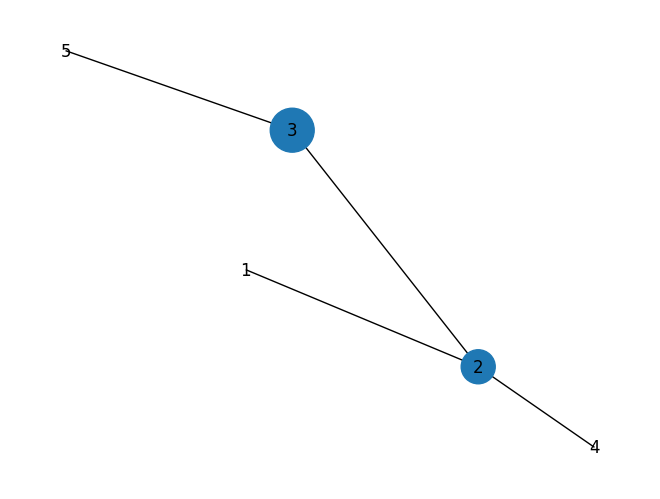

In [ ]:
# Assume you have a dictionary 'station_coordinates' with station names as keys and (latitude, longitude) tuples as values

# Get node sizes based on transfer_counts_result
node_sizes = [transfer_counts_result.get(station, 0) * 100 for station in G.nodes()]  # Scale size for better visualization

# Get node positions from station_coordinates
pos = {station: station_coordinates[station] for station in G.nodes()}

# Draw the graph with node sizes and positions
nx.draw(G, pos=pos, with_labels=True, node_size=node_sizes)
plt.show()